In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
#build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
#hyper parameters
block_size = 5 #context size
embdims = 30 #number of embeding dimensions
non = 300 #number of neurons in hidden layer

In [8]:
#build the dataset
def build_dataset(words):
    X, Y = [], []

    for w in words:
    
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [9]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,embdims), generator=g)
W1 = torch.randn((block_size*embdims, non), generator=g) * (5/3)/(embdims*block_size)**0.5
b1 = torch.randn(non, generator=g) * 0.001
W2 = torch.randn((non, 27), generator=g) * 0.001
b2 = torch.randn(27, generator=g) * 0.001

bngain = torch.ones((1, non))
bnbias = torch.zeros((1, non))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
stepi, lossi = [], []

54837


In [16]:
for i in range(200000):
    #minibatch construct
    bsize = 32
    
    ix = torch.randint(0, Xtr.shape[0], (bsize,))
    
    #forward pass
    emb = C[Xtr[ix]]
    hpreact = emb.view(-1, embdims*block_size) @ W1 + b1 #hidden layer pre activaation
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix], label_smoothing=0.0)
    #print(loss.item())   
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    if i < 100000:
        lr = 0.1
    else:
        if i < 150000: 
            lr = 0.01
        else: 
            lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
    if i % 10000 == 0:
        print(i/10000,': ', loss.item())
    # break

0.0 :  3.2641377449035645
1.0 :  2.7681896686553955
2.0 :  2.3311924934387207
3.0 :  2.1323165893554688
4.0 :  1.8399380445480347
5.0 :  1.8643380403518677
6.0 :  2.151791572570801
7.0 :  1.9462718963623047
8.0 :  1.909009337425232
9.0 :  1.6953543424606323
10.0 :  2.6425557136535645
11.0 :  1.99495267868042
12.0 :  1.9248974323272705
13.0 :  2.1740379333496094
14.0 :  2.010483741760254
15.0 :  1.591496467590332
16.0 :  1.9034764766693115
17.0 :  1.4306987524032593
18.0 :  1.6981353759765625
19.0 :  1.8663198947906494


torch.Size([32, 300])


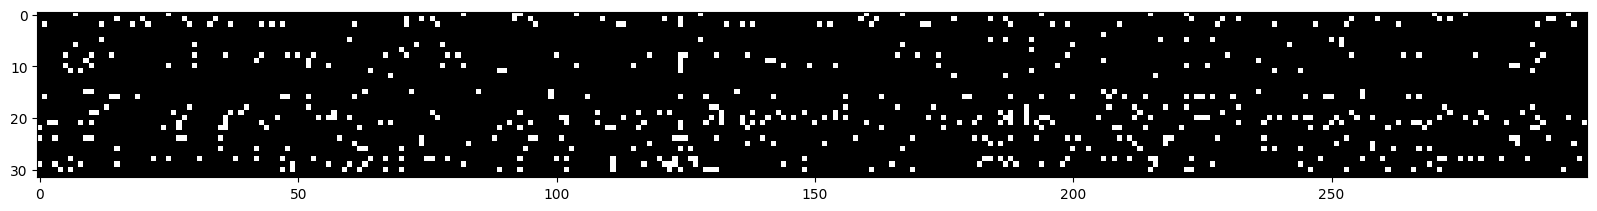

In [17]:
print(h.shape)
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [18]:
emb = C[Xdev]
hpreact = emb.view(-1, embdims*block_size) @ W1 + b1 #hidden layer pre activaation
hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

1.9960001707077026


In [13]:
2.0275490283966064

2.0275490283966064

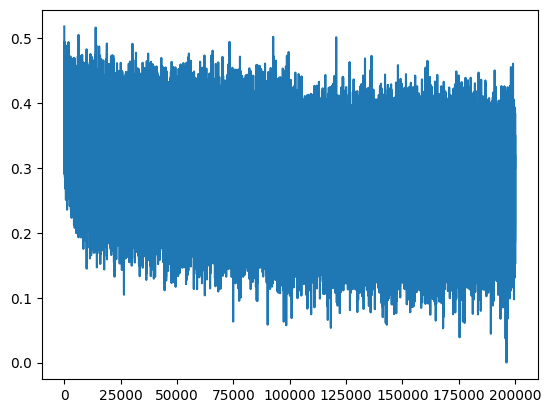

In [19]:
plt.plot(stepi, lossi)

In [20]:
#calibrate the batch norm at the end of training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdims=True)
    bnstd = hpreact.std(0, keepdim=True)

In [22]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(200):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
          emb = C[torch.tensor([context])] # (1,block_size,d)
          hpreact = emb.view(-1, embdims*block_size) @ W1 + b1 #hidden layer pre activaation
          hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
          h = torch.tanh(hpreact)
          logits = h @ W2 + b2
          probs = F.softmax(logits, dim=1)
          ix = torch.multinomial(probs, num_samples=1, generator=g).item()
          context = context[1:] + [ix]
          out.append(ix)
          if ix == 0:
                break
    
    print(''.join(itos[i] for i in out))

junide.
jakari.
julisaa.
adita.
jimritolia.
saree.
kalina.
cyriel.
vianna.
daine.
imbras.
jaicay.
artez.
aveum.
kyfor.
majon.
nasie.
hazani.
coreaya.
jocelynn.
brittan.
binswyn.
leana.
snoa.
jimonselledgor.
mattisi.
ziriah.
kathan.
jayreli.
isaye.
mirajel.
jemah.
dawad.
pharco.
arriyan.
jasiriana.
lynson.
ahmii.
laveroni.
themia.
tawat.
frandly.
kaleen.
ikiysaine.
marlene.
kafar.
saela.
antel.
chan.
jazlon.
jacden.
jaaliyah.
graeten.
waylin.
vyon.
elvin.
havaim.
hadel.
grim.
bracen.
osia.
noaklyn.
dennessy.
crystin.
arvin.
kessiannie.
jamontavita.
deric.
kazir.
abria.
olliah.
terry.
breus.
dasia.
natallynn.
derris.
parria.
meondra.
darius.
mattison.
dedick.
jacobin.
syniveen.
journey.
tivna.
julie.
maraf.
lanaya.
aleyhan.
tresti.
roseir.
deryiah.
kalvin.
nevia.
maul.
lacicea.
avryne.
jakira.
josaly.
brighteri.
khalielah.
bhadi.
aubreileo.
vanna.
kelan.
zyari.
erias.
meadayrah.
braydon.
eyton.
zachariah.
haneverett.
lennex.
akin.
lazarian.
tiyona.
isemya.
lowen.
aleisha.
ekston.
alejah.